In [294]:
import numpy as np
import sys
import torch
import gym
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [412]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, n_actions, gamma):
        super(ActorCritic, self).__init__()
        self.common = nn.Linear(state_dim,128)
        self.action_layer = nn.Linear(128, n_actions)
        self.critic_layer = nn.Linear(128, 1)
        
        self.logprobs = []
        self.values = []
        self.rewards = []

        self.gamma = gamma
    
    def clear(self):
        self.logprobs.clear()
        self.values.clear()
        self.rewards.clear()

    def forward(self, x):
        # x = torch.from_numpy(x).float().to(device)
        x = torch.from_numpy(x).float()
        x = F.relu(self.common(x))

        critic_value = self.critic_layer(x)

        probs = F.softmax(self.action_layer(x),dim=0)
        dist = Categorical(probs)
        action = dist.sample()

        self.logprobs.append(dist.log_prob(action))
        self.values.append(critic_value)

        return action.item()

    def get_dat_loss(self):
        rewards = []
        discount_reward = 0
        for reward in self.rewards[::-1]:
            discount_reward = reward + self.gamma * discount_reward
            rewards.append(discount_reward)
        rewards.reverse()
        
        # rewards = torch.tensor(rewards).to(device)
        rewards = torch.tensor(rewards)
        reward_len = len(rewards)
        # normalize
        rewards = (rewards - rewards.mean()) / (rewards.std())
        rewards.resize_(reward_len, 1)

        cum_loss = 0

        for logprob, value, reward in zip(self.logprobs, self.values, rewards):
            advantage = (reward - value.item())
            actor_loss = -logprob * advantage
            critic_loss = F.smooth_l1_loss(value, reward)
            cum_loss += (actor_loss + critic_loss)
        
        return cum_loss

In [421]:
lr = 0.001
betas = (0.9, 0.999)
gamma = 0.99
episodes = 10000
max_iterations = 10000
goal = 490
plot_iters = 10

In [422]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# env = gym.make('LunarLander-v2')
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
# A2C = ActorCritic(state_dim, n_actions, gamma).to(device)
A2C = ActorCritic(state_dim, n_actions, gamma)
optimizer = optim.Adam(A2C.parameters(), lr=lr, betas=betas)

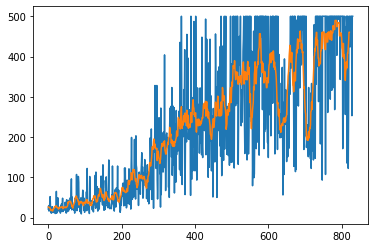

training complete


In [423]:
episode_rewards = []
for episode in range(episodes):
    obs = env.reset()
    total_reward = 0
    for iter in range(max_iterations):
        action  = A2C(obs)
        obs, reward, done, _ = env.step(action)
        A2C.rewards.append(reward)
        total_reward += reward
        if done:
            break
    
    episode_rewards.append(total_reward)
    optimizer.zero_grad()
    loss = A2C.get_dat_loss()
    loss.backward()
    optimizer.step()
    A2C.clear()

    if sum(episode_rewards[-10:])/10 > goal:
        torch.save(A2C.state_dict(), f'{env.unwrapped.spec.id}.pth')
        print("training complete")
        break
    
    if episode%plot_iters == 0:
        clear_output(wait=True)
        plt.plot(episode_rewards)
        avg_rewards = np.convolve(episode_rewards, np.ones(plot_iters)/plot_iters, mode='valid')
        plt.plot(avg_rewards)
        plt.pause(0.00000000001)
    

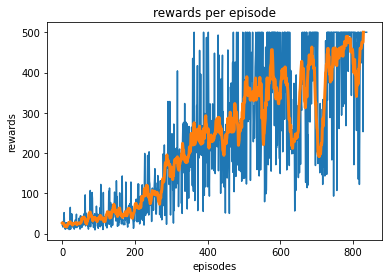

In [456]:
plt.plot(episode_rewards)
plt.plot(np.convolve(episode_rewards, np.ones(plot_iters)/plot_iters, mode='valid'),linewidth=3)
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.title('rewards per episode')
plt.savefig('CartPole-v1_rperepisode.png',dpi=300)

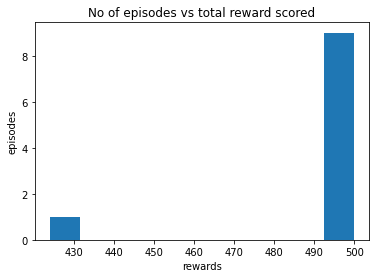

In [454]:
model = ActorCritic(state_dim, n_actions, gamma)
model.load_state_dict(torch.load("CartPole-v1.pth"))
model.eval()
rewards_per_episode = []
for episode in range(10):
    done = False
    total_reward = 0
    obs = env.reset()
    while not done:
        with torch.no_grad():
            action = model(obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
    rewards_per_episode.append(total_reward)

_ = plt.hist(rewards_per_episode)
plt.xlabel('rewards')
plt.ylabel('episodes')
plt.title('No of episodes vs total reward scored')
plt.savefig('CartPole-v1.pth_evaluation.png',dpi=300)

In [491]:
lr = 0.02
betas = (0.9, 0.999)
gamma = 0.99
episodes = 10000
max_iterations = 10000
goal = 200
plot_iters = 10

In [492]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
# A2C = ActorCritic(state_dim, n_actions, gamma).to(device)
A2C = ActorCritic(state_dim, n_actions, gamma)
optimizer = optim.Adam(A2C.parameters(), lr=lr, betas=betas)

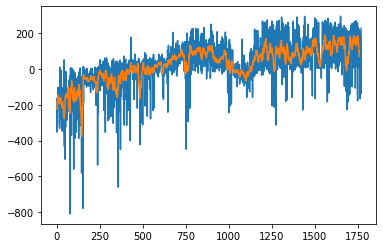

training complete


In [493]:
episode_rewards = []
best = 0
for episode in range(episodes):
    obs = env.reset()
    total_reward = 0
    for iter in range(max_iterations):
        action  = A2C(obs)
        obs, reward, done, _ = env.step(action)
        if reward > 99:
            done = True
        A2C.rewards.append(reward)
        total_reward += reward
        if done:
            break
    
    episode_rewards.append(total_reward)
    optimizer.zero_grad()
    loss = A2C.get_dat_loss()
    loss.backward()
    optimizer.step()
    A2C.clear()

    if sum(episode_rewards[-10:])/10 > goal:
        torch.save(A2C.state_dict(), f'{env.unwrapped.spec.id}.pth')
        print("training complete")
        break
    
    if episode%plot_iters == 0:
        clear_output(wait=True)
        plt.plot(episode_rewards)
        avg_rewards = np.convolve(episode_rewards, np.ones(plot_iters)/plot_iters, mode='valid')
        plt.plot(avg_rewards)
        plt.pause(0.00000000001)
    

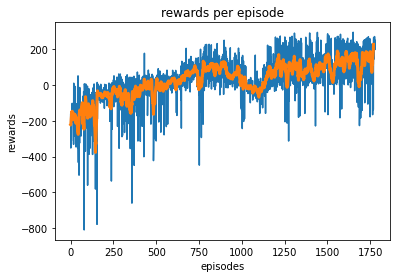

In [495]:
plt.plot(episode_rewards)
plt.plot(np.convolve(episode_rewards, np.ones(plot_iters)/plot_iters, mode='valid'),linewidth=3)
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.title('rewards per episode')
plt.savefig('LunarLander-v2_rperepisode.png',dpi=300)

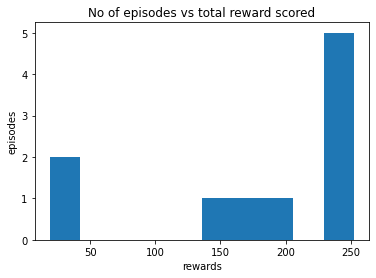

In [504]:
model = ActorCritic(state_dim, n_actions, gamma)
model.load_state_dict(torch.load("LunarLander-v2.pth"))
model.eval()
rewards_per_episode = []
for episode in range(10):
    done = False
    total_reward = 0
    obs = env.reset()
    while not done:
        with torch.no_grad():
            action = model(obs)
        obs, reward, done, _ = env.step(action)
        if reward > 99:
            done = True
        total_reward += reward
    rewards_per_episode.append(total_reward)

_ = plt.hist(rewards_per_episode)
plt.xlabel('rewards')
plt.ylabel('episodes')
plt.title('No of episodes vs total reward scored')
plt.savefig('LunarLander-v2.pth_evaluation.png',dpi=300)

In [519]:
lr = 0.001
betas = (0.9, 0.999)
gamma = 0.99
episodes = 10000
max_iterations = 10000
goal = -100
plot_iters = 10

In [520]:
env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
# A2C = ActorCritic(state_dim, n_actions, gamma).to(device)
A2C = ActorCritic(state_dim, n_actions, gamma)
optimizer = optim.Adam(A2C.parameters(), lr=lr, betas=betas)

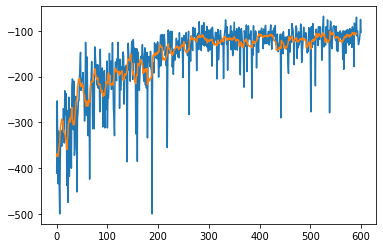

training complete


In [521]:
episode_rewards = []
for episode in range(episodes):
    obs = env.reset()
    total_reward = 0
    for iter in range(max_iterations):
        action  = A2C(obs)
        obs, reward, done, _ = env.step(action)
        if reward > 99:
            done = True
        A2C.rewards.append(reward)
        total_reward += reward
        if done:
            break
    
    episode_rewards.append(total_reward)
    optimizer.zero_grad()
    loss = A2C.get_dat_loss()
    loss.backward()
    optimizer.step()
    A2C.clear()

    if sum(episode_rewards[-10:])/10 > goal and episode > 100:
        torch.save(A2C.state_dict(), f'{env.unwrapped.spec.id}.pth')
        print("training complete")
        break
    
    if episode%plot_iters == 0:
        clear_output(wait=True)
        plt.plot(episode_rewards)
        avg_rewards = np.convolve(episode_rewards, np.ones(plot_iters)/plot_iters, mode='valid')
        plt.plot(avg_rewards)
        plt.pause(0.00000000001)
    

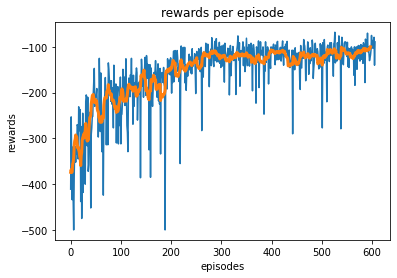

In [522]:
plt.plot(episode_rewards)
plt.plot(np.convolve(episode_rewards, np.ones(plot_iters)/plot_iters, mode='valid'),linewidth=3)
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.title('rewards per episode')
plt.savefig('Acrobot-v1_rperepisode.png',dpi=300)

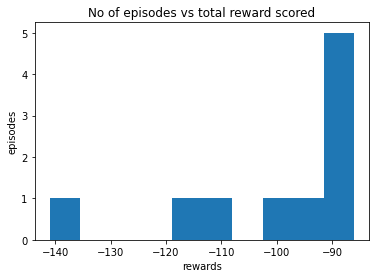

In [524]:
model = ActorCritic(state_dim, n_actions, gamma)
model.load_state_dict(torch.load("Acrobot-v1.pth"))
model.eval()
rewards_per_episode = []
for episode in range(10):
    done = False
    total_reward = 0
    obs = env.reset()
    while not done:
        with torch.no_grad():
            action = model(obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
    rewards_per_episode.append(total_reward)

_ = plt.hist(rewards_per_episode)
plt.xlabel('rewards')
plt.ylabel('episodes')
plt.title('No of episodes vs total reward scored')
plt.savefig('Acrobot-v1.pth_evaluation.png',dpi=300)